<a href="https://colab.research.google.com/github/brockwilson120/simonSaysQLearning/blob/main/CreditFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Packages
!pip install tensorflow
!pip install numpy
!pip install pandas
!pip install sklearn.model_selection
!pip install matplotlib

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/creditcard.csv')

In [ ]:
print(len(np.where(df['Class'] == 1)[0]),
len(np.where(df['Class'] == 0)[0]))

492 284315


In [ ]:
argX =  df.drop(columns=['Class', 'Time'])
argY = df['Class']

In [ ]:
mean = argX.mean(axis=0) 

In [ ]:
argX -= mean

In [ ]:
std = argX.std(axis=0)

In [ ]:
argX /= std

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(argX, argY, test_size= .4)

In [ ]:
print(xTrain.shape, yTrain.shape)

(170884, 29) (170884,)


In [ ]:
print(f'Ratio of positive to negative is {len(np.where(yTrain == 1)[0])}:{len(np.where(yTrain == 0)[0])}')

Ratio of positive to negative is 319:170565


In [ ]:
weights_for_0 = 1 / len(np.where(yTrain == 0)[0])
weights_for_1 = 1 / len(np.where(yTrain == 1)[0])

In [ ]:
print(weights_for_0,weights_for_1)

5.862867528508194e-06 0.003134796238244514


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=(29,), activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 8)                 240       
                                                                 
 dense_34 (Dense)            (None, 4)                 36        
                                                                 
 dense_35 (Dense)            (None, 1)                 5         
                                                                 
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
metrics = [tf.keras.metrics.FalseNegatives(name='FN'),
           tf.keras.metrics.FalsePositives(name='FP'),
           tf.keras.metrics.TrueNegatives(name='TN'),
           tf.keras.metrics.TruePositives(name='TP'),
           tf.keras.metrics.Precision(name='Precision'),
           tf.keras.metrics.Recall(name='Recall')]

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
class_weight={0: weights_for_0, 1: weights_for_1}

In [ ]:
os.makedirs('saved_model')

In [ ]:
#@title Custom keras callback 
class customCallback(tf.keras.callbacks.Callback):
		def __init__(self):
			self.logList = []

		def on_train_end(self, logs=None):
			graph(new=self.logList)

		def on_epoch_end(self, epoch, logs=None):
			# print(logs)
			self.logList.append([logs['Recall'], logs['Precision'], logs['val_Recall'], logs['val_Precision']])


In [ ]:
#@title Graphing Function
newList = []

def graph(new=[], old=[]):

  if old: 
    fig, axs = plt.subplots(nrows=1, ncols=2)

    ax = axs[0]
    ax.bar(0, height=round(old[0]*100, 2), width=.2, label='Untrained accuracy')
    ax.bar(.25, height=round(old[2]*100, 2), width=.2, label='Trained accuracy')
    ax.set_xticks([0,.25])
    ax.set_xticklabels(['Untrained', 'Trained'])
    ax.legend(loc='upper left')
    ax.set_title('Accuracy')

    for i, v in enumerate([old[0], old[2]]):
      ax.text((.25 * i), round(v*100, 2) + 1, str(round(v*100, 2)) + '%', ha='center', color='black', fontweight='bold')


    ax2 = axs[1]
    
    ax2.bar(0, height=old[1], width=.2, label='Untrained loss')
    ax2.bar(.25, height=old[3], width=.2, label='Trained loss')
    ax2.set_xticks([0,.25])
    ax2.set_xticklabels(['Untrained', 'Trained'])
    ax2.legend(loc='upper right')
    ax2.set_title('Loss')
    ax2.set_yscale('log')

    for i, v in enumerate([old[1], old[3]]):
      ax2.text((.25 * i), v + .001 + -1 * ((i - 1) * 500), str(round(v, 4)), color='black', ha='center', fontweight='bold')

    fig.suptitle('Untrained vs Trained', fontweight='bold')
  elif new:
    fig, ax = plt.subplots(nrows=1, ncols=2)	
    # newList.append(new)

    x = []
    yAccuracy = []
    yLoss = []
    yValLoss = []
    yValAccuracy = []


    for a, b in enumerate(new):
      x.append(a)
      yLoss.append(b[0])
      yAccuracy.append(b[1])
      yValLoss.append(b[2])
      yValAccuracy.append(b[3])


    ax[0].plot(x, yAccuracy, label='Precision')
    ax[0].plot(x, yValAccuracy, '--', label='Validation Precision')
    ax[1].plot(x, yLoss, label='Recall')
    ax[1].plot(x, yValLoss, '--', label='Validation Recall')

    ax[0].set_title('Precision')
    ax[0].legend(bbox_to_anchor =(-.1, 0))
    ax[0].grid()
    ax[1].set_title('Recall')
    ax[1].legend(bbox_to_anchor =(1.85, 0))
    ax[1].grid()

    fig.suptitle('Each Epoch', fontweight='bold')

  plt.show()

In [ ]:
checkCall = [customCallback()]

model.fit(xTrain, yTrain, validation_split= .2, batch_size=2048, epochs=20, callbacks=[checkCall], class_weight=class_weight, verbose=2)

In [ ]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
tf.keras.models.load_model('saved_model/my_model')

In [ ]:
prediction = model.predict(xTest)

# Input test data the model has never seen before to get a rough accuracy rating

Text(0.5, 1.0, 'Predictions')

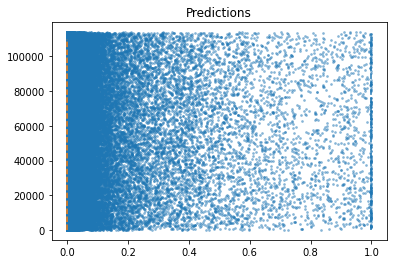

In [147]:
#@title Default title text
predDF = pd.DataFrame(zip(prediction, yTest))
predDF.columns = ['Prediction', 'Quality']
plt.plot([1,1], [0,110000], '--')
plt.plot([0,0], [0,110000], '--')
plt.scatter(predDF['Prediction'], np.arange(len(predDF['Prediction'])), s=np.pi, alpha=.4)
plt.title('Predictions')


In [ ]:
predDF

,Prediction,Quality
0,[0.009284645],0
1,[0.10207382],0
2,[0.08230367],0
3,[0.002710849],0
4,[0.27003634],0
...,...,...
113918,[0.06543216],0
113919,[0.07340613],0
113920,[0.008853763],0
113921,[0.15734589],0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
acc = accuracy_score(yTest, prediction.round())
print(acc)

0.9797758134880578


In [ ]:
print('Fraud instances: ', len(np.where(yTest == 1)[0]), '\nNonFraud: ', len(np.where(yTest == 0)[0]))


Fraud instances:  173 
NonFraud:  113750


# Due to the extreme difference of the ratios, this isnt an accurate accuracy

In [ ]:
accList1 = []
accList2 = []
for x in np.where(yTest == 1):
  accList1.append(x)
  accList2.append(prediction[x])

# Measuring accuracy of only fraud instances

In [ ]:
l1 = np.array(accList1)
l2 = np.array(accList2)
# accuracy_score(l1[0], l2[0])
zount=0
for x in l2[0].round():
  if x == 1: zount += 1

Roughly 90% accuracy

In [ ]:
zount / len(l2[0])

0.9017341040462428